In [18]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sns.set_context('talk')
sns.set_style('white')

from scipy.stats import norm, t


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
drug = [  99.,  110.,  107.,  104.,  103.,  105.,  105.,  110.,   99.,
        109.,  100.,  102.,  104.,  104.,  100.,  104.,  101.,  104.,
        101.,  100.,  109.,  104.,  105.,  112.,   97.,  106.,  103.,
        101.,  101.,  104.,   96.,  102.,  101.,  100.,   92.,  108.,
         97.,  106.,   96.,   90.,  109.,  108.,  105.,  104.,  110.,
         92.,  100.]

placebo = [  95.,  105.,  103.,   99.,  104.,   98.,  103.,  104.,  102.,
         91.,   97.,  101.,  100.,  113.,   98.,  102.,  100.,  105.,
         97.,   94.,  104.,   92.,   98.,  105.,  106.,  101.,  106.,
        105.,  101.,  105.,  102.,   95.,   91.,   99.,   96.,  102.,
         94.,   93.,   99.,   99.,  113.,   96.]


drug_and_studying = [  98.,  105.,  104.,   110.,  108.,   98.,  103.,  104.,  102.,
         91.,   97.,  101.,  100.,  113.,   98.,  102.,  100.,  105.,
         97.,   109.,   92.,   98.,  105.,  106.,  101.,  106.,
        105.,  101.,  115.,  102.,   95.,   91.,   99.,   99.,  102.,
         94.,   99.,   99.,  113.,   100.]


studying = [  112.,  115.,  124.,   120.,  128.,   138.,  113.,  124.,  102.,
         101.,   127.,  111.,  100.,  121.,   118.,  112.,  100.,  105.,
         147.,   109.,   112.,   128.,  115.,  116.,  101.,  106.,
        105.,  111.,  115.,  112.,   95.,   121.,   129.,   139.,  102.,
         114.,   129.,   119.,  113.,   120.]

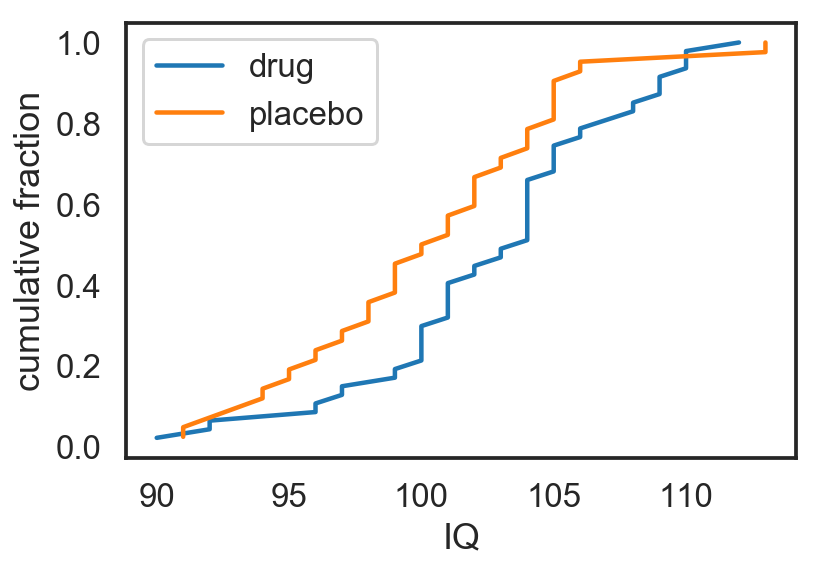

In [117]:
def ecdf_scatter(data, ax, label=None):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    ax.plot(x, y, label=label)
    
fig, ax = plt.subplots(nrows=1, ncols=1)
ecdf_scatter(drug, ax, label='drug')
ecdf_scatter(placebo, ax, label='placebo')
ax.set_xlabel('IQ')
ax.set_ylabel('cumulative fraction')
plt.legend()
plt.savefig('../assets/images/drug-two-group.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'frequency')

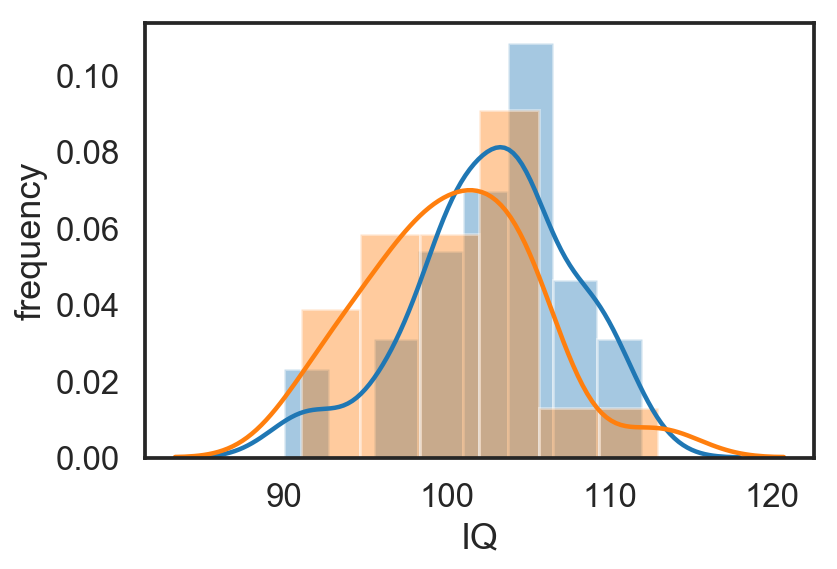

In [118]:
fig, ax = plt.subplots()
sns.distplot(drug)
sns.distplot(placebo)
ax.set_xlabel('IQ')
ax.set_ylabel('frequency')

In [119]:
from scipy.stats import ttest_ind

ttest_ind(drug, placebo)

Ttest_indResult(statistic=2.280670163432955, pvalue=0.025011500508647616)

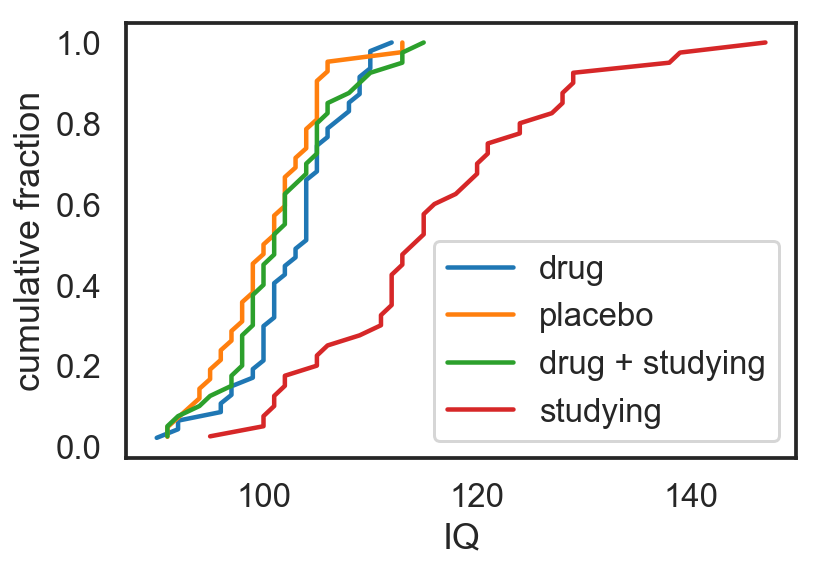

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ecdf_scatter(drug, ax, label='drug')
ecdf_scatter(placebo, ax, label='placebo')
ecdf_scatter(drug_and_studying, ax, label='drug + studying')
ecdf_scatter(studying, ax, label='studying')
ax.set_xlabel('IQ')
ax.set_ylabel('cumulative fraction')
plt.legend()
plt.savefig('../assets/images/drug-four-group.png', dpi=300, bbox_inches='tight')

In [121]:
from scipy.stats import f_oneway

f_oneway(drug, placebo, drug_and_studying)

F_onewayResult(statistic=2.403088960707778, pvalue=0.09457235703157442)

In [122]:
ttest_ind(drug, placebo)

Ttest_indResult(statistic=2.280670163432955, pvalue=0.025011500508647616)

In [123]:
ttest_ind(drug, drug_and_studying)

Ttest_indResult(statistic=0.9409554147596239, pvalue=0.3493942196130586)

In [124]:
ttest_ind(drug_and_studying, placebo)

Ttest_indResult(statistic=1.1448161210230416, pvalue=0.25569885246431134)

In [125]:
ttest_ind(drug_and_studying, studying)

Ttest_indResult(statistic=-6.873160104190295, pvalue=1.3719216944562557e-09)

/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  """


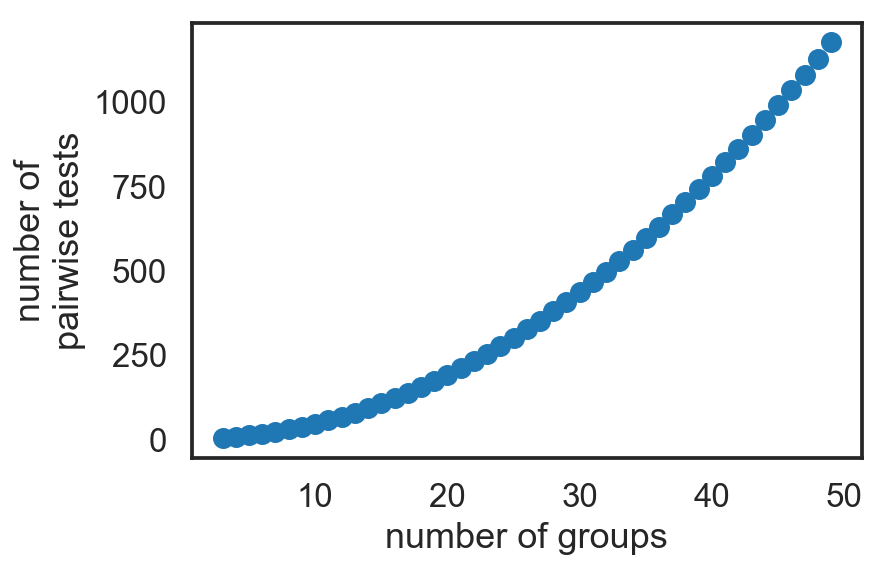

In [126]:
from scipy.misc import comb


n_groups = np.arange(3, 50)
n_tests = comb(n_groups, 2)
plt.scatter(n_groups, n_tests)
plt.xlabel('number of groups')
plt.ylabel('number of\npairwise tests')
plt.savefig('../assets/images/groups_choose_two.png', dpi=300, bbox_inches='tight')

In [127]:
import pandas as pd
import janitor

df = pd.DataFrame()
df['group'] = ['drug'] * len(drug) + ['placebo'] * len(placebo) + ['drug_studying'] * len(drug_and_studying) + ['studying'] * len(studying)
df['iq'] = drug + placebo + drug_and_studying + studying
df = df.label_encode('group')

In [128]:
df.drop_duplicates(subset=['group'])

,group,iq,group_enc
0,drug,99.0,0
47,placebo,95.0,2
89,drug_studying,98.0,1
129,studying,112.0,3


In [129]:
n_groups = len(df['group'].unique())
with pm.Model() as model:
    # Model Parameters
    mu = pm.Normal('mu', mu=0, sd=10, shape=n_groups)
    sigma = pm.HalfCauchy('sigma', beta=5, shape=n_groups)
    nu = pm.Exponential('nu', lam=1/29.)

    # Likelihood
    like = pm.StudentT(
        'like',
        mu=mu[df['group_enc']],
        sd=sigma[df['group_enc']],
        nu=nu,
        observed=df['iq'].values
    )
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:07<00:00, 1312.48draws/s]
The acceptance probability does not match the target. It is 0.8879285657752934, but should be close to 0.8. Try to increase the number of tuning steps.


In [130]:
import arviz as az

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26c7d080>,
      dtype=object)

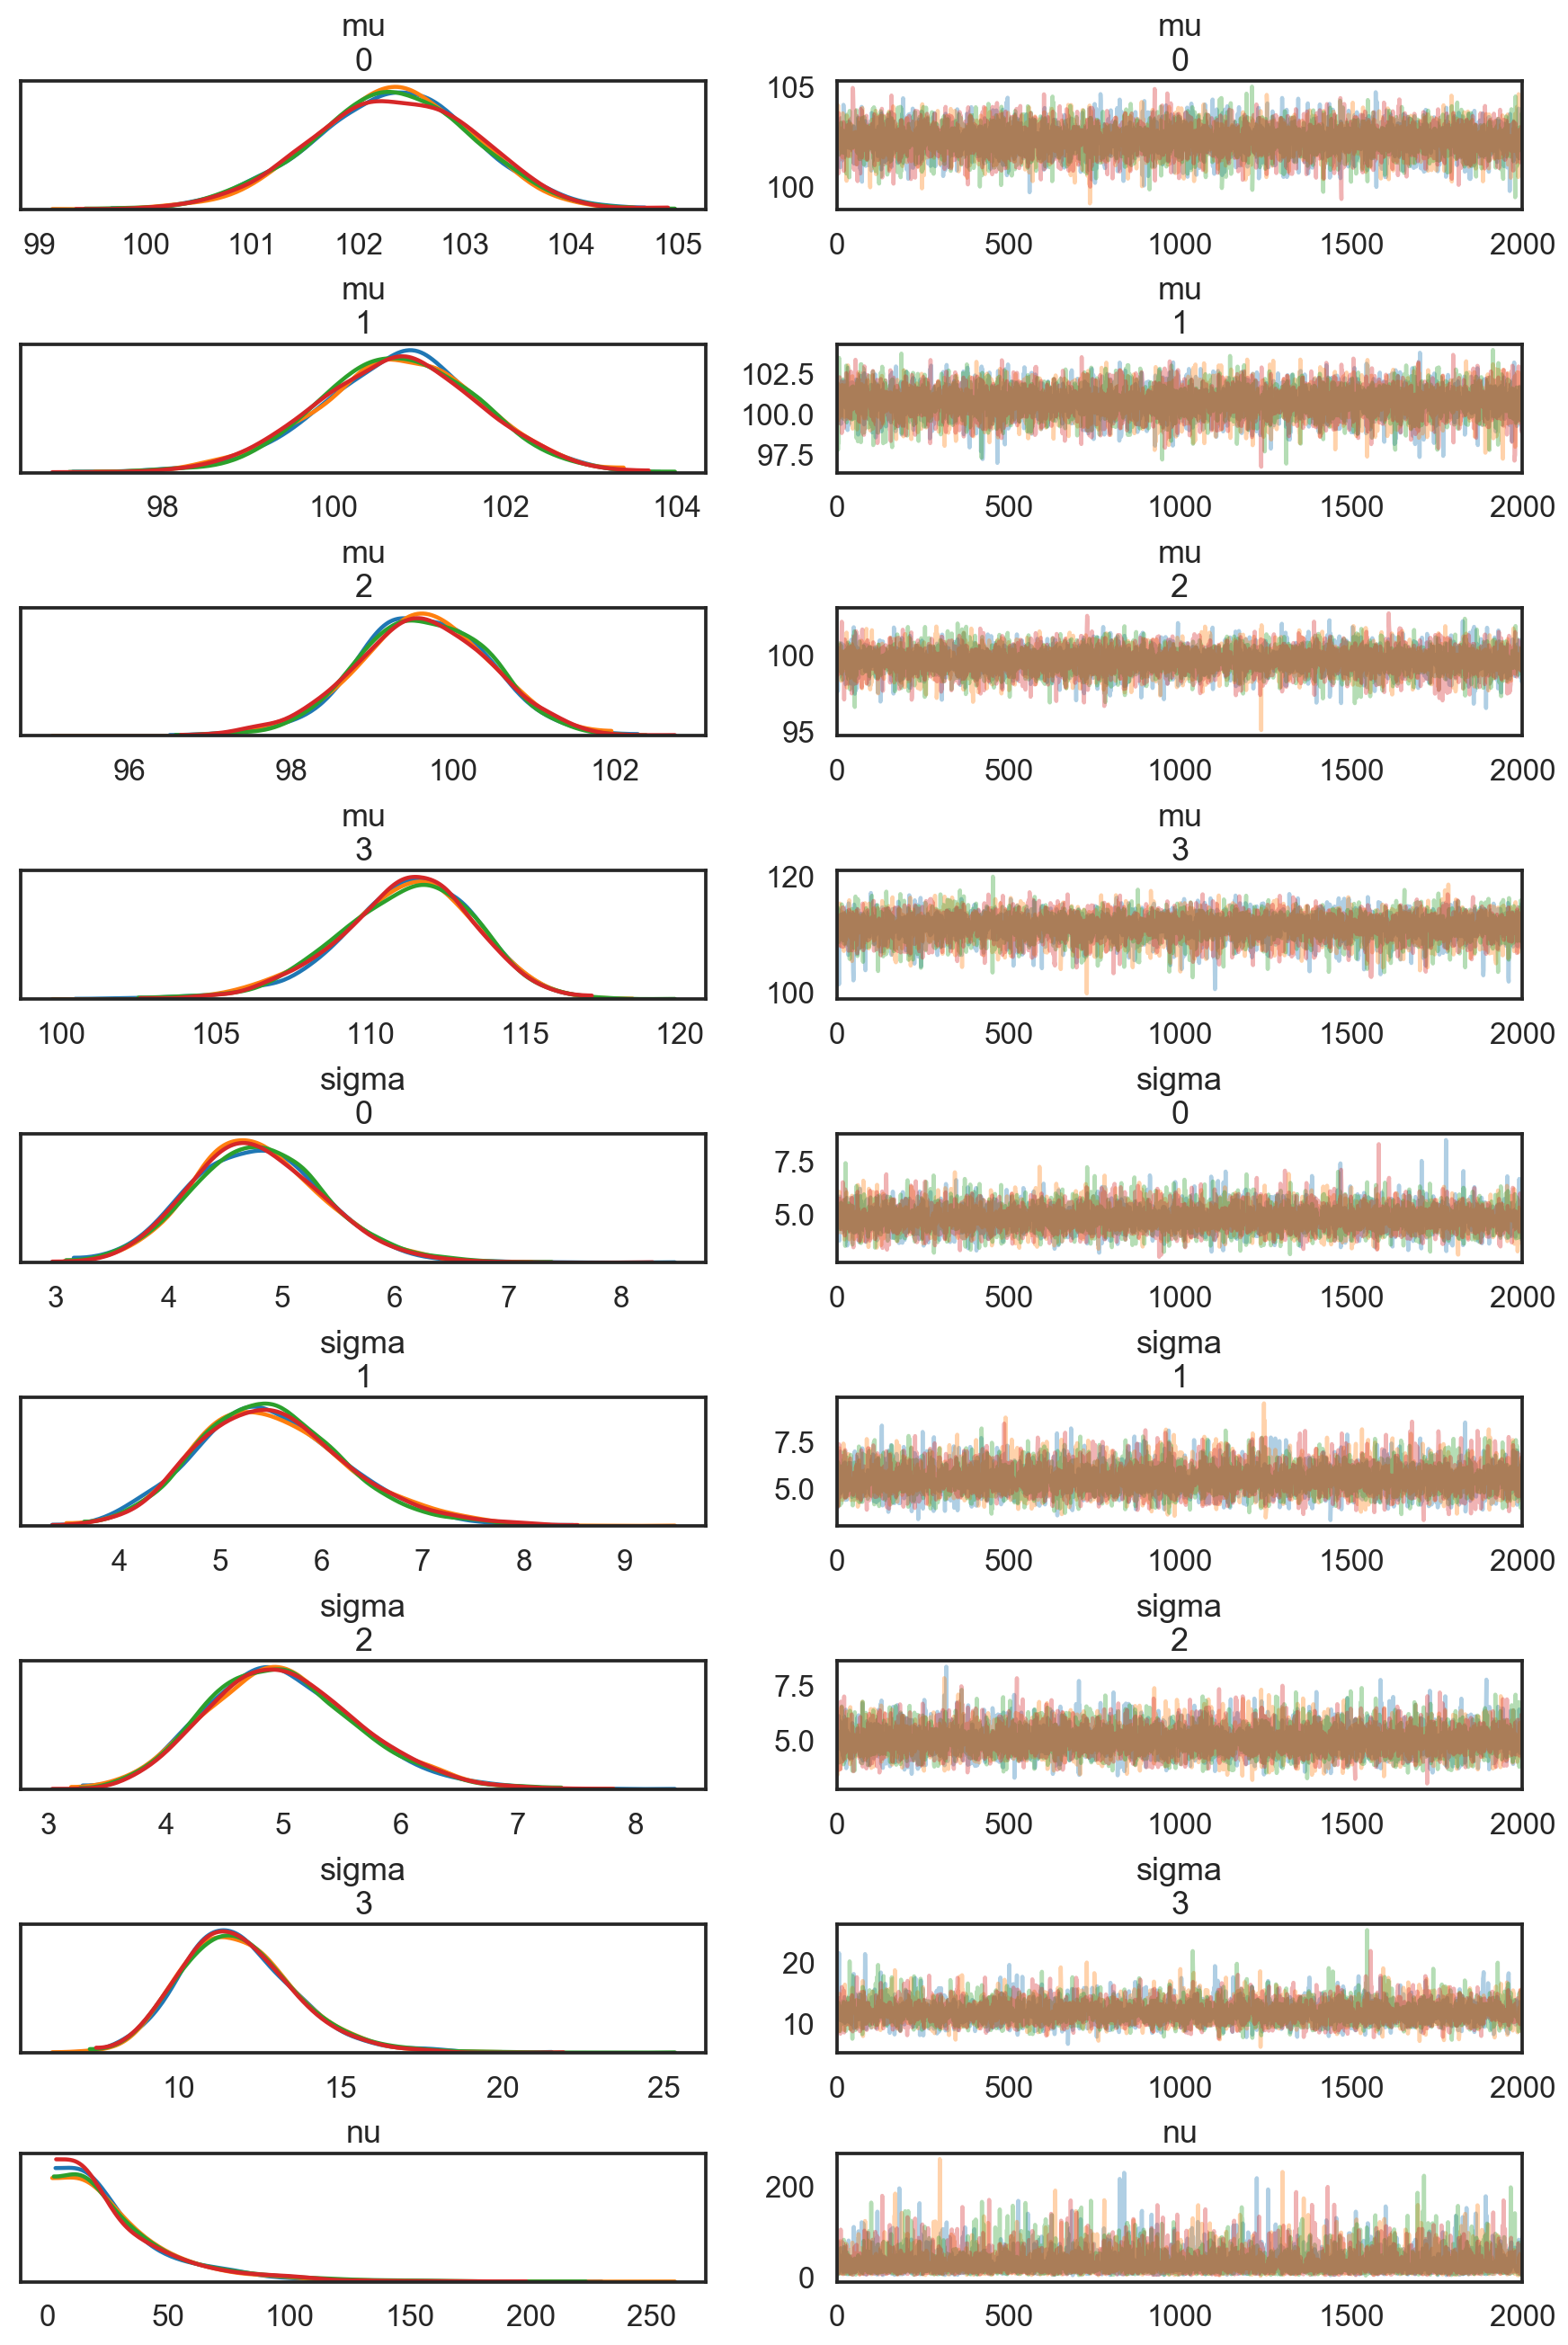

In [131]:
az.plot_trace(trace, )

/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


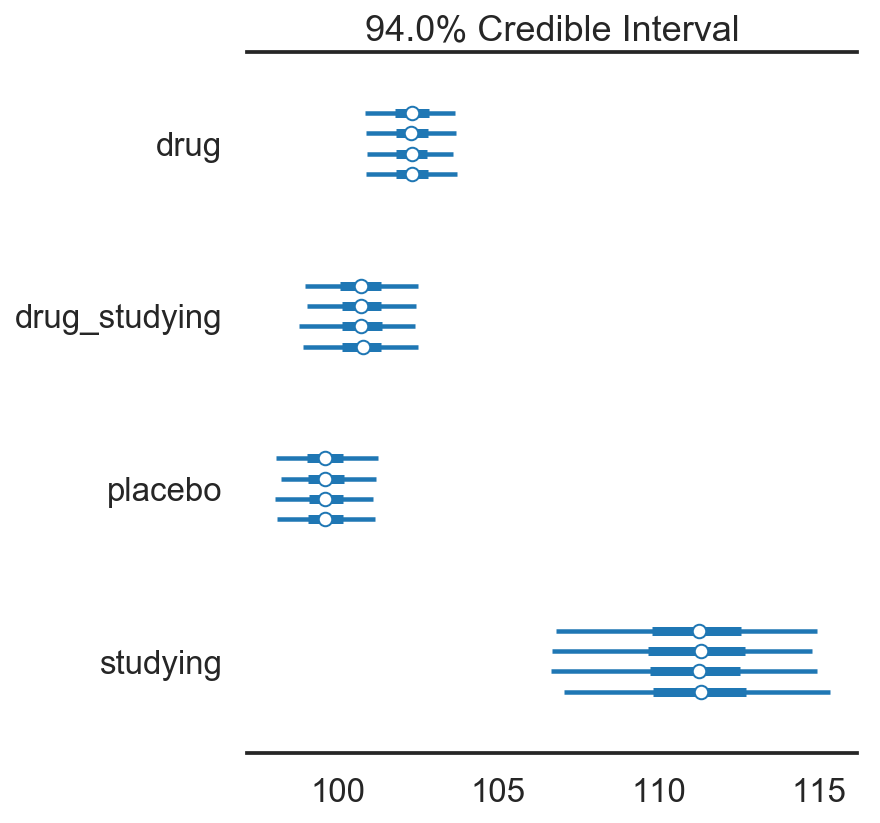

In [132]:
fig, axes = az.plot_forest(trace, var_names=['mu'])
axes[0].set_yticklabels(reversed(['drug', 'drug_studying', 'placebo', 'studying']))
plt.savefig('../assets/images/drug-four-group-forest.png', dpi=300, bbox_inches='tight')